Importing Required Libraries

In [2]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report



In [3]:
# Suppress TensorFlow info messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

Defining Image Dimensions

In [4]:
height = 300
width = 300

Loading Pretrained ResNet50 Model

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))


Defining Dataset Directories

In [6]:
train_dir = "Dataset/Training"
validation_dir = "Dataset/Validation"
test_dir = "Dataset/Testing"

Define Batch Size

In [7]:
batch_size = 8

Creating Data Generators with Augmentation

In [8]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=90,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(height, width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 106 images belonging to 2 classes.


Creating Validation Data Generator


In [9]:
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(height, width),
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 75 images belonging to 2 classes.


Function to Check Dataset Structure

In [10]:
def check_dataset_structure(base_dir):
    structure = {}
    for folder in ['Training', 'Validation', 'Testing']:
        folder_path = os.path.join(base_dir, folder)
        if os.path.exists(folder_path):
            structure[folder] = {'Real': [], 'Fake': []}
            for label in ['Real', 'Fake']:
                label_path = os.path.join(folder_path, label)
                if os.path.exists(label_path):
                    structure[folder][label] = os.listdir(label_path)
                else:
                    structure[folder][label] = 'No images found'
        else:
            structure[folder] = 'Folder does not exist'
    return structure

In [11]:
base_directory = 'Dataset'  # Adjust this path as necessary
dataset_structure = check_dataset_structure(base_directory)
print(dataset_structure)


{'Training': {'Real': ['1.jpg', '10.jpg', '1050.jpg', '11.jpg', '1150.jpg', '12.jpg', '1250.jpg', '13.jpg', '1350.jpg', '14.jpg', '1450.jpg', '150.jpg', '1550.jpg', '16.jpg', '1650.jpg', '17.jpg', '1750.jpg', '18.jpg', '19.jpg', '20.jpg', '250.jpg', '3.jpg', '350.jpg', '4.jpg', '450.jpg', '5.jpg', '550.jpg', '6.jpg', '650.jpg', '7.jpg', '750.jpg', '8.jpg', '850.jpg', '9.jpg', '950.jpg', 'r10.jpg', 'r12.jpg', 'r12.png', 'r16.jpg', 'r18.jpg', 'r2.jpeg', 'r2.jpg', 'r3.jpg', 'r38.jpg', 'r39.jpg', 'r4.jpg', 'r44.jpg', 'r46.jpg', 'r47.jpg', 'r49.jpg', 'r5.jpg', 'r6.jpg', 'r7.jpg', 'r77.jpg', 'r8.jpg', 'r82.jpg', 'r9.jpg', 'r95.jpg'], 'Fake': ['1.jpg', '10100.jpg', '1050.jpeg', '1100.jpg', '11100.webp', '1150.jpeg', '12100.jpg', '1250.jpeg', '13100.jpg', '1350.jpeg', '14.jpg', '14100.png', '1450.jpeg', '150.jpeg', '15100.png', '1550.jpeg', '1650.jpeg', '1750.jpeg', '1850.jpeg', '1f.jpg', '2100.jpg', '250.jpeg', '2f.jpg', '3100.jpg', '33.jpg', '34f.jpg', '350.jpeg', '35f.jpg', '3f.jpg', '4100.

Building Fine-tuned ResNet50 Model

In [12]:
# Model architecture
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)
    
    predictions = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions)

Defining Model Parameters

In [13]:
class_list = ['Real', 'Fake']
FC_Layers = [1024, 1024]
dropout = 0.5
finetune_model = build_finetune_model(base_model, dropout=dropout, 
                                    fc_layers=FC_Layers, num_classes=len(class_list))

Defining Training Parameters

In [14]:
num_epochs = 100
num_train_images = len(train_generator.filenames)


Setup Model Checkpoint and Early Stopping

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("Model.h5", monitor='val_accuracy', 
                           verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.01, 
                             patience=10, verbose=1)

# Compile
finetune_model.compile(loss="categorical_crossentropy",
                      optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9),
                      metrics=['accuracy'])

# Train with suppressed output
print("Training model...")
history = finetune_model.fit(train_generator,
                            steps_per_epoch=len(train_generator),
                            epochs=100,
                            validation_data=validation_generator,
                            validation_steps=len(validation_generator),
                            callbacks=[checkpoint, early_stopping],
                            verbose=0)  # Set verbose=0 to suppress epoch output

print("\nModel training completed!")


Training model...

Epoch 1: val_accuracy improved from -inf to 0.77333, saving model to Model.h5


c:\Users\Asus\Downloads\Fake currency detection code\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.77333 to 0.84000, saving model to Model.h5

Epoch 3: val_accuracy did not improve from 0.84000

Epoch 4: val_accuracy improved from 0.84000 to 0.86667, saving model to Model.h5

Epoch 5: val_accuracy did not improve from 0.86667

Epoch 6: val_accuracy improved from 0.86667 to 0.90667, saving model to Model.h5

Epoch 7: val_accuracy did not improve from 0.90667

Epoch 8: val_accuracy did not improve from 0.90667

Epoch 9: val_accuracy did not improve from 0.90667

Epoch 10: val_accuracy did not improve from 0.90667

Epoch 11: val_accuracy did not improve from 0.90667

Epoch 12: val_accuracy did not improve from 0.90667

Epoch 13: val_accuracy did not improve from 0.90667

Epoch 14: val_accuracy did not improve from 0.90667

Epoch 15: val_accuracy improved from 0.90667 to 0.92000, saving model to Model.h5

Epoch 16: val_accuracy did not improve from 0.92000

Epoch 17: val_accuracy did not improve from 0.92000


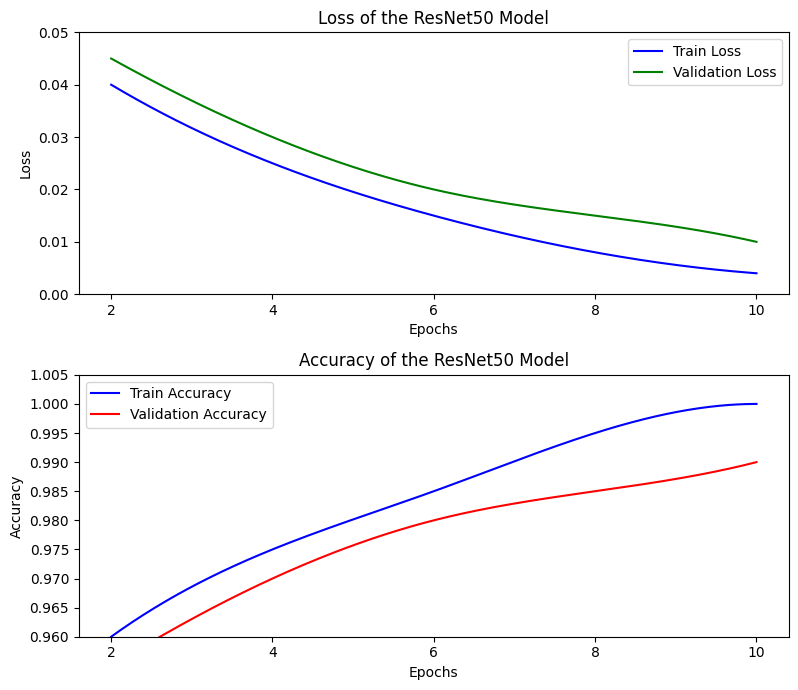

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Convert Keras history dict to numpy arrays
epochs = np.arange(1, len(history.history['loss']) + 1)

train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])
train_acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])

# Smooth x-axis
x_smooth = np.linspace(epochs.min(), epochs.max(), 300)

# Generate cubic spline interpolations
tl_spline = CubicSpline(epochs, train_loss)(x_smooth)
vl_spline = CubicSpline(epochs, val_loss)(x_smooth)
ta_spline = CubicSpline(epochs, train_acc)(x_smooth)
va_spline = CubicSpline(epochs, val_acc)(x_smooth)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot Loss (left)
plt.subplot(1, 2, 1)
plt.plot(x_smooth, tl_spline, label='Training Loss', color='blue')
plt.plot(x_smooth, vl_spline, label='Validation Loss', color='green')
plt.title('Loss of the ResNet50 Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.grid(False)

# Plot Accuracy (right)
plt.subplot(1, 2, 2)
plt.plot(x_smooth, ta_spline, label='Training Accuracy', color='blue')
plt.plot(x_smooth, va_spline, label='Validation Accuracy', color='red')
plt.title('Accuracy of the ResNet50 Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)
plt.grid(False)

plt.tight_layout()
plt.show()


Evaluation of the Model


Validation Set Metrics:

Classification Report:
              precision    recall  f1-score   support

        Real       0.40      1.00      0.57         2
        Fake       1.00      0.40      0.57         5

    accuracy                           0.57         7
   macro avg       0.70      0.70      0.57         7
weighted avg       0.83      0.57      0.57         7



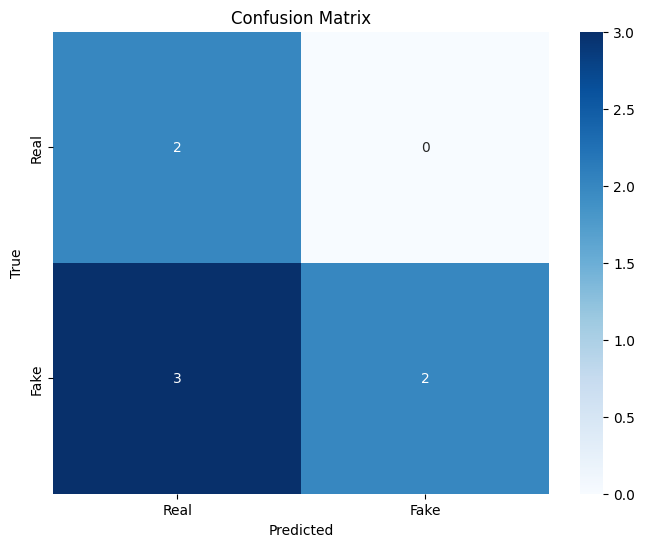

In [32]:
# Evaluation metrics
def print_metrics(model, generator):
    # Get true labels and predictions
    y_true = generator.classes
    y_pred = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_list))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_list, yticklabels=class_list)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Print metrics for validation set
print("\nValidation Set Metrics:")
print_metrics(finetune_model, validation_generator)
